<h1><center> Data Preparation - Data Preparation phase Notebook  </center></h1>

In [329]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [330]:
# Data Insertion
df = pd.read_csv(r'../../telco_customers.csv')

### Data Cleaning

##### Initial data preparation

In [331]:
# Capitalize all columns for consistency
df.rename(columns = lambda x: "".join([w[0].upper() + w[1:] for w in x.split()]), inplace = True)

# Drop CustomerID, as it holds no bearing on the future predictions
df = df.drop("CustomerID", axis=1)

df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

numerical_features = ['Tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = df.columns.difference(numerical_features)

# Set column data type
df[numerical_features] = df[numerical_features].apply(pd.to_numeric, errors='coerce')

df.dtypes

Gender               object
SeniorCitizen        object
Partner              object
Dependents           object
Tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

##### Missing Value Analysis

In [332]:
# Get all columns that hold null values
df.columns[df.isnull().sum() != 0].tolist()

['TotalCharges']

In [333]:
# Replace the null values with 0 (it is a result of customers with 1 month tenure)
df["TotalCharges"] = df["TotalCharges"].fillna(0)
df["TotalCharges"].isnull().sum()

0

##### Outlier Analysis

Identifying Outliers using the IQR Method:

In [334]:
for feature in numerical_features:
    copy_df = df.copy()
    copy_df[feature] = sorted(copy_df[feature])
    Q1, Q3 = np.percentile(copy_df[feature], [25, 75])
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR) 
    upper_bound = Q3 + (1.5 * IQR) 
    out = copy_df[(copy_df[feature] < lower_bound) | (copy_df[feature] > upper_bound)]
    print(f"The column '{feature}' has {out.shape[0]} outliers!")
del copy_df

The column 'Tenure' has 0 outliers!
The column 'MonthlyCharges' has 0 outliers!
The column 'TotalCharges' has 0 outliers!


Identifying Outliers using the Z-Score Method:

In [335]:
for feature in numerical_features:
    copy_df = df.copy()
    mean = np.mean(copy_df[feature])
    std = np.std(copy_df[feature])
    copy_df["charges_z_score"] = (copy_df[feature] - mean) / std

    # create empty list
    outlier_indexes = []

    # add index numbers of outliers to list
    outlier_indexes.extend(copy_df.index[copy_df['charges_z_score'] > 3].tolist())
    outlier_indexes.extend(copy_df.index[copy_df['charges_z_score'] < -3].tolist())

    new_data = copy_df.drop(copy_df.index[outlier_indexes])
    
    print(f"The column '{feature}' has {df.shape[0] - new_data.shape[0]} outliers!")
del copy_df

The column 'Tenure' has 0 outliers!
The column 'MonthlyCharges' has 0 outliers!
The column 'TotalCharges' has 0 outliers!


##### Label Encoding

In [336]:
# Encoding
from sklearn.preprocessing import LabelEncoder

features_to_one_hot_encode = [feature for feature in categorical_features if df[feature].nunique() > 2]
features_to_label_encode = [feature for feature in categorical_features if df[feature].nunique() == 2]

one_hot_df = pd.get_dummies(df[features_to_one_hot_encode])
one_hot_df.columns = one_hot_df.columns.str.replace(' ', '_')

# Label encode the specified columns
label_encode_df = df[features_to_label_encode].apply(LabelEncoder().fit_transform)

# Combine the encoded dataframes
df_enc = pd.concat([df.drop(columns=features_to_one_hot_encode+features_to_label_encode), one_hot_df, label_encode_df], axis=1)

df_enc.columns

Index(['Tenure', 'MonthlyCharges', 'TotalCharges', 'Contract_Month-to-month',
       'Contract_One_year', 'Contract_Two_year', 'DeviceProtection_No',
       'DeviceProtection_No_internet_service', 'DeviceProtection_Yes',
       'InternetService_DSL', 'InternetService_Fiber_optic',
       'InternetService_No', 'MultipleLines_No',
       'MultipleLines_No_phone_service', 'MultipleLines_Yes',
       'OnlineBackup_No', 'OnlineBackup_No_internet_service',
       'OnlineBackup_Yes', 'OnlineSecurity_No',
       'OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes',
       'PaymentMethod_Bank_transfer_(automatic)',
       'PaymentMethod_Credit_card_(automatic)',
       'PaymentMethod_Electronic_check', 'PaymentMethod_Mailed_check',
       'StreamingMovies_No', 'StreamingMovies_No_internet_service',
       'StreamingMovies_Yes', 'StreamingTV_No',
       'StreamingTV_No_internet_service', 'StreamingTV_Yes', 'TechSupport_No',
       'TechSupport_No_internet_service', 'TechSupport_Yes', 'Chur

##### Data splitting

In [337]:
X = df_enc.drop(columns=['Churn'])
y = df_enc['Churn']

# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, random_state = 8)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

print(f"Training features shape: {X_train.shape}")
print(f"Training features shape: {X_test.shape}")
print(f"Training features shape: {X_val.shape}")

Training features shape: (4225, 40)
Training features shape: (1409, 40)
Training features shape: (1409, 40)


### Feature Scaling

In [338]:
y_train

608     0
5007    0
5329    1
3485    1
6530    0
       ..
1265    0
3229    1
3810    0
2147    0
4252    0
Name: Churn, Length: 4225, dtype: int32

Viewing the distribution of the Numerical Features

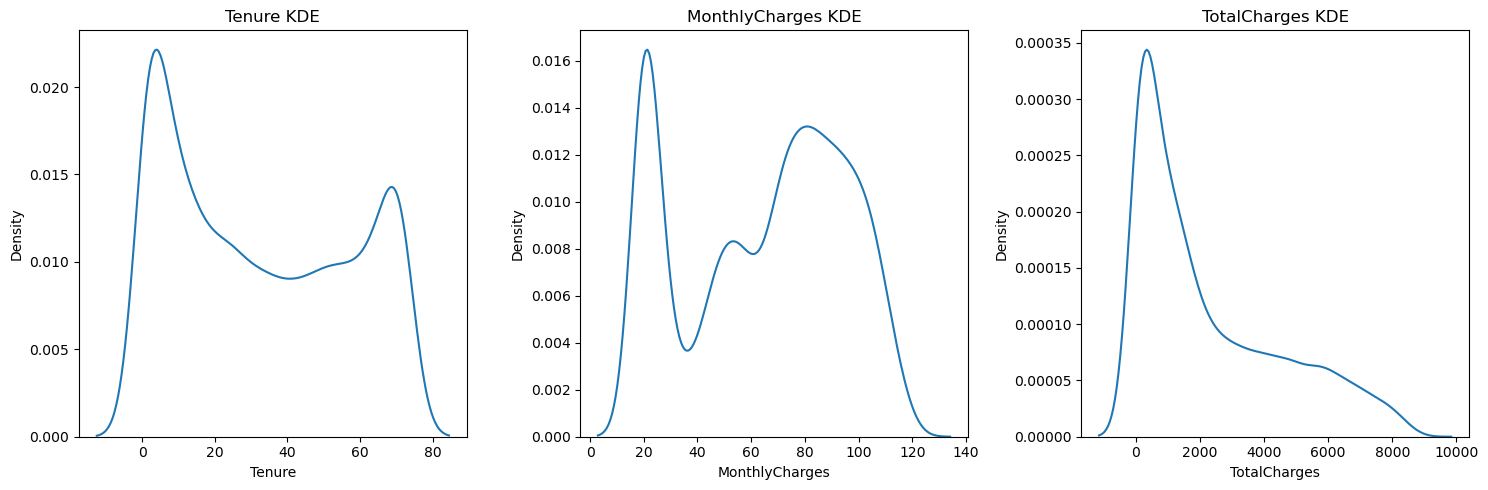

In [339]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=1, ncols=len(numerical_features), figsize=(15, 5))

for i, feature in enumerate(numerical_features):
    sns.kdeplot(df_enc[feature], ax=axs[i])
    axs[i].set_title("{} KDE".format(feature))

plt.tight_layout()
plt.show()

In [340]:
mms = MinMaxScaler() # Normalization

# fit the scaler on the training data and transform it
X_train[numerical_features] = mms.fit_transform(X_train[numerical_features])

# transform the validation and test data using the same scaler
X_val[numerical_features] = mms.transform(X_val[numerical_features])
X_test[numerical_features] = mms.transform(X_test[numerical_features])


We have 2 options for data scaling : 
1) Normalization 
2) Standardization

Since most of the algorithms assume the data to be normally (Gaussian) distributed, Normalization is done for features whose data does not display normal distribution and standardization is carried out for features that are normally distributed where their values are huge or very small as compared to other features.

Normalization : tenure, MonthlyCharges and TotalCharges features are normalized as they displayed a right skewed and bimodal data distribution.

Standardization : None of the features are standardized for the above data. Since we don't have to, as we have normalized it already


### Feature Engineering & Selection

In [341]:
# Low-Variance Feature Selection
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold = 0.1)
selector.fit(X_train)

# Get columns to keep and remove
cols_to_keep = X_train.columns[selector.get_support()]
cols_to_remove = X_train.columns[~selector.get_support()]

# Remove low-variance features from the dataset
# df_enc = df_enc[cols_to_keep]

print(f"Variables to be removed based on low-variance: {cols_to_remove}")

Variables to be removed based on low-variance: Index(['MonthlyCharges', 'TotalCharges', 'MultipleLines_No_phone_service',
       'PhoneService'],
      dtype='object')


In [342]:
# Univariate Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif

# Set number of features to keep
df_enc_copy = df_enc.copy()
k = 10

# Select top k features based on ANOVA f-value
selector = SelectKBest(score_func=f_classif, k=k)
selector.fit(df_enc_copy.drop('Churn', axis=1), df_enc_copy['Churn'])

# Get column names of top k features
top_k_cols = df_enc_copy.drop('Churn', axis=1).columns[selector.get_support()]

# Add back target variable column to the list
top_k_cols = list(top_k_cols) + ['Churn']

print(f"Top {k} most relevant variables based on Univariate Feature Selection: \n {top_k_cols}")

Top 10 most relevant variables based on Univariate Feature Selection: 
 ['Tenure', 'Contract_Month-to-month', 'Contract_Two_year', 'DeviceProtection_No', 'InternetService_Fiber_optic', 'OnlineBackup_No', 'OnlineSecurity_No', 'PaymentMethod_Electronic_check', 'TechSupport_No', 'TechSupport_No_internet_service', 'Churn']


In [343]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

def recursive_feature_selection(df, target, n_features):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df.drop(target, axis=1), df[target], test_size=0.2, random_state=42)

    

    # Initialize a logistic regression model
    model = LogisticRegression()
    # Initialize the RFE object with the logistic regression model
    rfe = RFE(model)
    for i in range(X_train.shape[1], n_features, -1):
        # Set the number of features for the RFE object
        rfe.n_features_to_select = i
        # Fit the RFE object to the training data
        rfe.fit(X_train, y_train)
    # Get the selected feature indices from the RFE object
    selected_features = rfe.support_
    # Get the selected feature names from the dataframe
    feature_names = list(df.drop(target, axis=1).columns)
    selected_feature_names = [feature_names[i] for i in range(len(feature_names)) if selected_features[i]]
    # Fit a logistic regression model on the training set using the selected features
    model.fit(X_train[selected_feature_names], y_train)
    # Calculate the accuracy score on the testing set
    score = accuracy_score(y_test, model.predict(X_test[selected_feature_names]))
    # Print the selected features and the accuracy score
    print(f"Selected features: {selected_feature_names}")
    print(f"Accuracy score: {score}")

# recursive_feature_selection(df_enc, "Churn", 10)

In [344]:
# Over a hour, no result. Too many combinations in our case!

from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def exhaustive_feature_selection(df, target, n_features):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df.drop(target, axis=1), df[target], test_size=0.2, random_state=42)
    # Initialize a logistic regression model
    model = LogisticRegression()
    # Get the feature names from the dataframe
    feature_names = list(df.drop(target, axis=1).columns)
    # Get all possible combinations of features up to the given number of features
    feature_combinations = list(combinations(feature_names, n_features))
    # Initialize variables to store the best feature set and its accuracy score
    best_feature_set = None
    best_accuracy = 0
    # Iterate over all feature combinations and fit a logistic regression model using each set of features
    for feature_set in feature_combinations:
        # Fit the logistic regression model on the training set using the current feature set
        model.fit(X_train[list(feature_set)], y_train)
        # Calculate the accuracy score on the testing set
        score = accuracy_score(y_test, model.predict(X_test[list(feature_set)]))
        # Check if the current feature set has a higher accuracy score than the current best feature set
        if score > best_accuracy:
            best_feature_set = feature_set
            best_accuracy = score
    # Print the selected features and the accuracy score
    print(f"Selected features: {best_feature_set}")
    print(f"Accuracy score: {best_accuracy}")

# exhaustive_feature_selection(df_enc, "Churn", 5)

### Data Balancing

In [345]:
print(f"Proportion of Churn values in original data-set: {(df_enc['Churn'] == 1).sum()} out of {len(df_enc['Churn'])}")
print("With Churned amount:", round((df_enc['Churn'] == 1).sum() / len(df_enc['Churn']), 3) * 100, "%")  

Proportion of Churn values in original data-set: 1869 out of 7043
With Churned amount: 26.5 %


In [346]:
from imblearn.under_sampling import RandomUnderSampler

# Apply RandomUnderSampler to balance the classes
rus = RandomUnderSampler(sampling_strategy = 1)
X_res, y_res = rus.fit_resample(X_train, y_train)

# Combine the resampled features and target into a new DataFrame
df_balanced_rus = [X_res, y_res]

In [347]:
from imblearn.over_sampling import RandomOverSampler

# Apply RandomUnderSampler to balance the classes
ros = RandomOverSampler(sampling_strategy = 1)
X_res, y_res = rus.fit_resample(X_train, y_train)

# Combine the resampled features and target into a new DataFrame
df_balanced_ros = [X_res, y_res]


In [348]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy = 1)

# Apply SMOTE to balance the classes
X_res, y_res = sm.fit_resample(X_train, y_train)

# Combine the resampled features and target into a new DataFrame
df_balanced_smote = [X_res, y_res]

c:\Users\mikolaj.hilgert\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


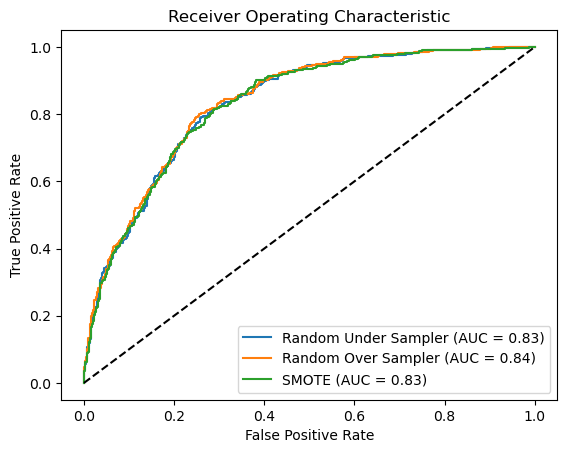

In [350]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# X_train and y_train are your training data
# instantiate LogisticRegression classifier with desired hyperparameters
clf = LogisticRegression()

# balanced_datasets is a list of balanced datasets (X_train, y_train)
# clf is your classifier object
# clf_name is the name of your classifier (for legend)
names = ["Random Under Sampler", "Random Over Sampler", "SMOTE"]
for i, data in enumerate([df_balanced_rus, df_balanced_ros, df_balanced_smote]):
    clf.fit(data[0], data[1])
    y_pred = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (names[i], roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()